In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
import glob

In [3]:
def histoplot(df, dfvar, num_bins = 10, range=None, figsize=(6, 4), title=""):
    
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    _, _, _ = ax0.hist(df[dfvar], num_bins, range, label=dfvar)
    ax0.set_xlabel(dfvar)
    ax0.set_ylabel('Events/bin')
    ax0.set_title(title)
    ax0.legend()
    fig.tight_layout()
    plt.show()

In [4]:
def plot_energy(df, num_bins = 20, xmin=2e+4, xmax=4e+4, figsize=(6, 4), title=""):
    energies = df.groupby("event").sum().amplitude.values
    
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    _, _, _ = ax0.hist(energies, num_bins, (xmin, xmax))
    ax0.set_xlabel("Event energy")
    ax0.set_ylabel('Events/bin')
    ax0.set_title(title)
    

    fig.tight_layout()
    plt.show()

In [5]:
def plot_time(df, num_bins = 20, xmin=0.0, xmax=5e+3, timebin=200, figsize=(6, 4), title=""):
    
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    _, _, _ = ax0.hist(df.time * timebin, num_bins, (xmin, xmax), weights=df.charge)
    ax0.set_xlabel("Event Time")
    ax0.set_ylabel('Events/bin')
    ax0.set_title(title)
    
    fig.tight_layout()
    plt.show()

In [6]:
def select_image_from_df(df, evtsel = 10):
    gevt = df.groupby('event')
    n = 8
    charge_matrix = np.zeros((n, n))
    for event_number, group in gevt:
        if event_number == evtsel:
            for _, row in group.iterrows():
                sensor_id = row['sensor_id']
                charge = row['amplitude']
                charge_matrix[sensor_id // n, sensor_id % n] = charge
            break
    return charge_matrix

In [7]:
def plot_image(charge_matrix, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(charge_matrix, cmap='viridis', interpolation='none')
    plt.colorbar(label='Charge')
    plt.title(f'Charge Matrix for Event {evtsel}')
    plt.xlabel('Sensor X')
    plt.ylabel('Sensor Y')
    plt.show()

In [8]:
def read_histograms(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    histograms = {}
    current_histogram = None
    bin_edges = []
    bin_values = []

    for line in lines:
        if line.startswith("# Histogram:"):
            if current_histogram:
                histograms[current_histogram] = (bin_edges, bin_values)
            current_histogram = line.split(":")[1].strip()
            bin_edges = []
            bin_values = []
        elif current_histogram and line.strip():
            parts = line.split()
            bin_edges.append(float(parts[0]))
            bin_edges.append(float(parts[1]))
            bin_values.append(float(parts[2]))
    
    if current_histogram:
        histograms[current_histogram] = (bin_edges, bin_values)

    return histograms


In [9]:
def plot_histogram(histograms, name, figsize=(6, 6)):
    edges, values = histograms[name]
    bin_edges = edges[::2]  # taking only the lower edges
    bin_width = edges[1] - edges[0]  # assuming uniform bin width
    
    plt.figure(figsize=figsize)    
    plt.bar(bin_edges, values, width=bin_width, align='edge')
    plt.title(f"Histogram: {name}")
    plt.xlabel("Bin")
    plt.ylabel("Count")
    plt.show()


In [10]:
def collect_images(df, n= 8):
    events = np.unique(df['event'])
    images = np.zeros((events.shape[0],n,n))
    gevt = df.groupby('event')
    i=0
    charge_matrix = np.zeros((n, n))
    for event_number, group in gevt:
        for _, row in group.iterrows():
            sensor_id = row['sensor_id']
            charge = row['amplitude']
            charge_matrix[sensor_id // n, sensor_id % n] = charge
        images[i]= charge_matrix
        i+=1
    return images

In [11]:
def dinamic_range_caen(spe=16e-3, vmax=4): # in volts
    return vmax/spe

In [12]:
def linearity_sipm(M,  Nph, PDE=1):
    return M * (1.0 - np.exp(-(PDE*Nph)/M))

In [13]:
dinamic_range_caen(spe=16e-3, vmax=4)

250.0

In [14]:
linearity_sipm(14e+3, 200.0)/200

0.9928910353316778

## Z uniform case

In [15]:
rootdir = "/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasUniformTest"
filenm = "sensor_data_1.csv"


In [16]:
sddf = pd.read_csv(f"{rootdir}/{filenm}", header=0)
sddf

,event,sensor_id,time,charge
0,700,45,0.0,149.0
1,700,45,1.0,127.0
2,700,45,2.0,102.0
3,700,45,3.0,60.0
4,700,45,4.0,64.0
...,...,...,...,...
763831,468,43,15.0,3.0
763832,468,43,16.0,5.0
763833,468,43,18.0,1.0
763834,468,43,19.0,2.0


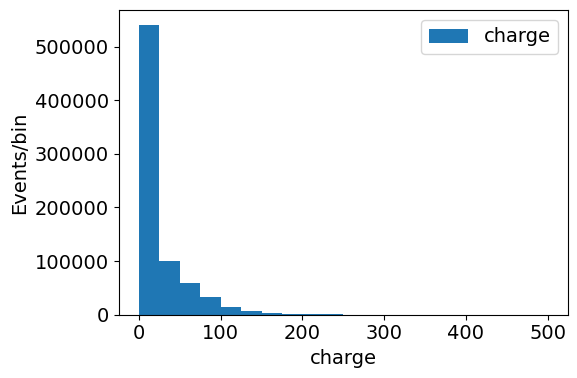

In [17]:
histoplot(sddf, "charge", num_bins = 20, range=(0,500), figsize=(6, 4), title="")

This is the charge per time/bin (in bins of 200 ns). Since the dinamic range of our caen digitizer is 250, we can
see simultaneously SPE and charge without saturating the ADC

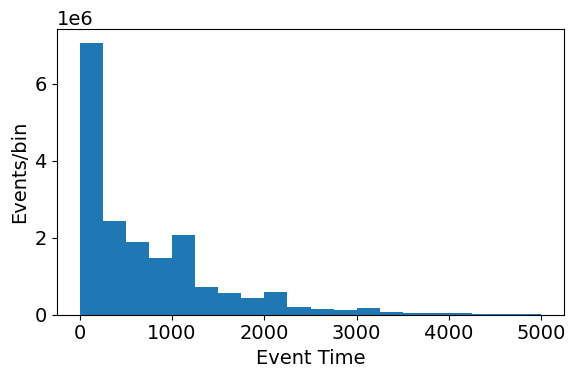

In [19]:
plot_time(sddf, num_bins = 20, xmin=0.0, xmax=5e+3, timebin=200, figsize=(6, 4), title="")

### Integrated sensor data
- Sensors and chage

In [20]:
filenm = "isensor_data_1.csv"
isddf = pd.read_csv(f"{rootdir}/{filenm}", header=0)

In [21]:
isddf

,event,sensor_id,amplitude
0,700,45,713.0
1,700,62,552.0
2,700,30,633.0
3,700,37,711.0
4,700,59,506.0
...,...,...,...
35116,768,23,426.0
35117,768,27,358.0
35118,768,35,363.0
35119,768,33,359.0


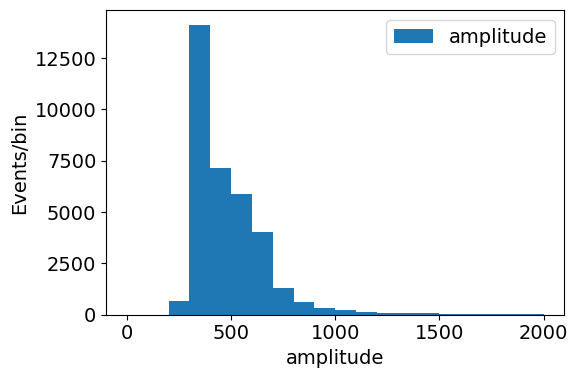

In [22]:
histoplot(isddf, "amplitude", num_bins = 20, range=(0,2000), figsize=(6, 4), title="")

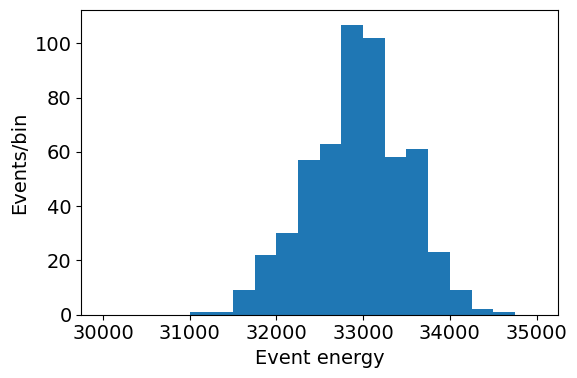

In [23]:
plot_energy(isddf, num_bins = 20, xmin=3e+4, xmax=3.5e+4,figsize=(6, 4), title="")

In [ ]:
gname = "gamma_interactions_1.csv"
dfg = pd.read_csv(f"{rootdir}/{gname}", header=0).sort_values(by='event').reset_index(drop=True)
dfg.rename(columns={'event': 'event_id',
                    'x': 'initial_x',
                    ' y': 'initial_y',
                    ' z': 'initial_z'}, 
                    inplace=True)
dfg

In [ ]:
histoplot(dfg, "initial_x", num_bins = 50, figsize=(6, 4), title="")

In [ ]:
histoplot(dfg, "initial_y", num_bins = 50, figsize=(6, 4), title="")

In [ ]:
histoplot(dfg, "initial_z", num_bins = 50, figsize=(6, 4), title="")

### Plot a few events

In [ ]:
evtsel = 0
charge_matrix = select_image_from_df(isddf,evtsel)


In [ ]:
charge_matrix

In [ ]:
plot_image(charge_matrix)

## Z according to exp(-z/x0)

In [ ]:
rootdir = "/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasZX0Test"
filenm = "sensor_data_1.csv"
zddf = pd.read_csv(f"{rootdir}/{filenm}", header=0)

In [ ]:
histoplot(zddf, "charge", num_bins = 20, range=(0,500), figsize=(6, 4), title="")

In [ ]:
plot_time(zddf, num_bins = 20, xmin=0.0, xmax=5e+3, timebin=200, figsize=(6, 4), title="")

In [ ]:
filenm = "isensor_data_1.csv"
izddf = pd.read_csv(f"{rootdir}/{filenm}", header=0)

In [ ]:
histoplot(izddf, "amplitude", num_bins = 20, range=(0,2000), figsize=(6, 4), title="")

In [ ]:
plot_energy(izddf, num_bins = 20, xmin=3e+4, xmax=3.5e+4,figsize=(6, 4), title="")

In [ ]:
gname = "gamma_interactions_1.csv"
dfgz = pd.read_csv(f"{rootdir}/{gname}", header=0).sort_values(by='event').reset_index(drop=True)
dfgz.rename(columns={'event': 'event_id',
                    'x': 'initial_x',
                    ' y': 'initial_y',
                    ' z': 'initial_z'}, 
                    inplace=True)

In [ ]:
histoplot(dfgz, "initial_x", num_bins = 50, figsize=(6, 4), title="")

In [ ]:
histoplot(dfgz, "initial_y", num_bins = 50, figsize=(6, 4), title="")

In [ ]:
histoplot(dfgz, "initial_z", num_bins = 50, figsize=(6, 4), title="")

In [ ]:
charge_matrix = select_image_from_df(izddf,evtsel)

In [ ]:
charge_matrix

In [ ]:
plot_image(charge_matrix)